In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import preprocessing
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Generate training data with a constant noise

In [2]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return  10 * np.sin(2 * np.pi * (x)) + epsilon
train_size = 100
noise = 0.3
X1 = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
Y1 = f(X1, sigma=noise)
Y_true1 = f(X1, sigma=0.0)

X2 = np.linspace(2, 2.25, 20).reshape(-1, 1)
Y2 = f(X2, sigma=noise)
Y_true2 = f(X2, sigma=0.0)

X3 = np.linspace(2.25, 2.5, 20).reshape(-1, 1)
Y3 = f(X3, sigma=noise)
Y_true3 = f(X3, sigma=0.0)

X = np.concatenate((X1,X2,X3),axis=0)
Y = np.concatenate((Y1,Y2,Y3),axis=0)
Y_true = np.concatenate((Y_true1,Y_true2,Y_true3),axis=0)
print(X.shape)

(140, 1)


Visualize training data

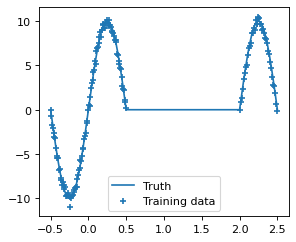

In [3]:
cm = 1/2.54 
fig, ax = plt.subplots(1, figsize=(9*cm, 8*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.scatter(X, Y, marker='+', label='Training data')
ax.plot(X, Y_true, label='Truth')
plt.legend(loc='lower center')

Loss function, Distribution layer, and KL diverenge

In [4]:
def NLL(y, distr): 
  return -distr.log_prob(y) 


def normal_sp(params): 
  return tfp.distributions.Normal(loc=params, scale=noise) #only the mean parameter is learnable


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X.shape[0])
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X.shape[0])

Build the network

In [5]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(32,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(1,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params)


model = Model(inputs=inputs, outputs=dist)
model.compile(Adam(learning_rate=0.001), loss=NLL) 

model_params = Model(inputs=inputs, outputs=params)
model.summary()

C:\Users\Administrateur\anaconda3\envs\VUB\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\Administrateur\anaconda3\envs\VUB\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipout  (None, 20)               80        
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 32)               1344      
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 20)               1320      
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 1)                42        
 ut)                                                         

Train the network

In [6]:
epoch = 6000
model.fit(X, Y, epochs=epoch, verbose=1)

Epoch 1/6000
5/5 [==============================] - 2s 2ms/step - loss: 300.2751
Epoch 2/6000
5/5 [==============================] - 0s 2ms/step - loss: 300.6888
Epoch 3/6000
5/5 [==============================] - 0s 2ms/step - loss: 299.1790
Epoch 4/6000
5/5 [==============================] - 0s 2ms/step - loss: 298.0882
Epoch 5/6000
5/5 [==============================] - 0s 2ms/step - loss: 299.1388
Epoch 6/6000
5/5 [==============================] - 0s 1ms/step - loss: 298.4249
Epoch 7/6000
5/5 [==============================] - 0s 1ms/step - loss: 299.1659
Epoch 8/6000
5/5 [==============================] - 0s 1ms/step - loss: 297.2700
Epoch 9/6000
5/5 [==============================] - 0s 2ms/step - loss: 296.7176
Epoch 10/6000
5/5 [==============================] - 0s 2ms/step - loss: 296.4951
Epoch 11/6000
5/5 [==============================] - 0s 2ms/step - loss: 293.8268
Epoch 12/6000
5/5 [==============================] - 0s 2ms/step - loss: 293.0963
Epoch 13/6000
5/5 [======

5/5 [==============================] - 0s 1ms/step - loss: 75.9661
Epoch 102/6000
5/5 [==============================] - 0s 1ms/step - loss: 82.1689
Epoch 103/6000
5/5 [==============================] - 0s 1ms/step - loss: 75.1326
Epoch 104/6000
5/5 [==============================] - 0s 1ms/step - loss: 84.2548
Epoch 105/6000
5/5 [==============================] - 0s 2ms/step - loss: 80.2412
Epoch 106/6000
5/5 [==============================] - 0s 2ms/step - loss: 77.2433
Epoch 107/6000
5/5 [==============================] - 0s 2ms/step - loss: 81.8602
Epoch 108/6000
5/5 [==============================] - 0s 2ms/step - loss: 77.8553
Epoch 109/6000
5/5 [==============================] - 0s 2ms/step - loss: 76.0502
Epoch 110/6000
5/5 [==============================] - 0s 1ms/step - loss: 79.0473
Epoch 111/6000
5/5 [==============================] - 0s 1ms/step - loss: 82.7915
Epoch 112/6000
5/5 [==============================] - 0s 2ms/step - loss: 75.6730
Epoch 113/6000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 66.1834
Epoch 201/6000
5/5 [==============================] - 0s 1ms/step - loss: 67.2695
Epoch 202/6000
5/5 [==============================] - 0s 2ms/step - loss: 72.8404
Epoch 203/6000
5/5 [==============================] - 0s 1ms/step - loss: 68.0911
Epoch 204/6000
5/5 [==============================] - 0s 1ms/step - loss: 63.3965
Epoch 205/6000
5/5 [==============================] - 0s 2ms/step - loss: 70.3442
Epoch 206/6000
5/5 [==============================] - 0s 1ms/step - loss: 67.0650
Epoch 207/6000
5/5 [==============================] - 0s 2ms/step - loss: 67.5261
Epoch 208/6000
5/5 [==============================] - 0s 2ms/step - loss: 67.6226
Epoch 209/6000
5/5 [==============================] - 0s 2ms/step - loss: 66.2007
Epoch 210/6000
5/5 [==============================] - 0s 2ms/step - loss: 66.2036
Epoch 211/6000
5/5 [==============================] - 0s 2ms/step - loss: 66.6433
Epoch 212/6000
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 57.3049
Epoch 301/6000
5/5 [==============================] - 0s 1ms/step - loss: 60.0998
Epoch 302/6000
5/5 [==============================] - 0s 2ms/step - loss: 57.8587
Epoch 303/6000
5/5 [==============================] - 0s 1ms/step - loss: 60.6798
Epoch 304/6000
5/5 [==============================] - 0s 1ms/step - loss: 58.9053
Epoch 305/6000
5/5 [==============================] - 0s 1ms/step - loss: 58.0753
Epoch 306/6000
5/5 [==============================] - 0s 1ms/step - loss: 57.7026
Epoch 307/6000
5/5 [==============================] - 0s 1ms/step - loss: 57.9930
Epoch 308/6000
5/5 [==============================] - 0s 2ms/step - loss: 59.1839
Epoch 309/6000
5/5 [==============================] - 0s 2ms/step - loss: 57.8521
Epoch 310/6000
5/5 [==============================] - 0s 2ms/step - loss: 57.4953
Epoch 311/6000
5/5 [==============================] - 0s 2ms/step - loss: 57.2732
Epoch 312/6000
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 54.7108
Epoch 401/6000
5/5 [==============================] - 0s 2ms/step - loss: 53.0889
Epoch 402/6000
5/5 [==============================] - 0s 2ms/step - loss: 51.5539
Epoch 403/6000
5/5 [==============================] - 0s 2ms/step - loss: 56.0788
Epoch 404/6000
5/5 [==============================] - 0s 2ms/step - loss: 51.2537
Epoch 405/6000
5/5 [==============================] - 0s 2ms/step - loss: 55.2518
Epoch 406/6000
5/5 [==============================] - 0s 2ms/step - loss: 53.2553
Epoch 407/6000
5/5 [==============================] - 0s 1ms/step - loss: 55.2540
Epoch 408/6000
5/5 [==============================] - 0s 2ms/step - loss: 55.5086
Epoch 409/6000
5/5 [==============================] - 0s 2ms/step - loss: 54.6675
Epoch 410/6000
5/5 [==============================] - 0s 1ms/step - loss: 54.0078
Epoch 411/6000
5/5 [==============================] - 0s 2ms/step - loss: 55.3143
Epoch 412/6000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 52.6115
Epoch 501/6000
5/5 [==============================] - 0s 2ms/step - loss: 51.1621
Epoch 502/6000
5/5 [==============================] - 0s 1ms/step - loss: 52.9750
Epoch 503/6000
5/5 [==============================] - 0s 2ms/step - loss: 50.0571
Epoch 504/6000
5/5 [==============================] - 0s 2ms/step - loss: 52.9114
Epoch 505/6000
5/5 [==============================] - 0s 2ms/step - loss: 51.5411
Epoch 506/6000
5/5 [==============================] - 0s 2ms/step - loss: 52.0359
Epoch 507/6000
5/5 [==============================] - 0s 2ms/step - loss: 52.0333
Epoch 508/6000
5/5 [==============================] - 0s 2ms/step - loss: 52.2097
Epoch 509/6000
5/5 [==============================] - 0s 2ms/step - loss: 51.1791
Epoch 510/6000
5/5 [==============================] - 0s 2ms/step - loss: 52.1893
Epoch 511/6000
5/5 [==============================] - 0s 2ms/step - loss: 52.5147
Epoch 512/6000
5/5 [===========

Epoch 600/6000
5/5 [==============================] - 0s 2ms/step - loss: 49.9672
Epoch 601/6000
5/5 [==============================] - 0s 2ms/step - loss: 49.7011
Epoch 602/6000
5/5 [==============================] - 0s 1ms/step - loss: 48.5690
Epoch 603/6000
5/5 [==============================] - 0s 1ms/step - loss: 51.2926
Epoch 604/6000
5/5 [==============================] - 0s 1ms/step - loss: 51.6848
Epoch 605/6000
5/5 [==============================] - 0s 2ms/step - loss: 52.7124
Epoch 606/6000
5/5 [==============================] - 0s 1ms/step - loss: 48.1817
Epoch 607/6000
5/5 [==============================] - 0s 1ms/step - loss: 50.7454
Epoch 608/6000
5/5 [==============================] - 0s 1ms/step - loss: 49.6952
Epoch 609/6000
5/5 [==============================] - 0s 2ms/step - loss: 48.0464
Epoch 610/6000
5/5 [==============================] - 0s 2ms/step - loss: 50.2026
Epoch 611/6000
5/5 [==============================] - 0s 2ms/step - loss: 51.5851
Epoch 612/6000
5

5/5 [==============================] - 0s 1ms/step - loss: 46.7920
Epoch 700/6000
5/5 [==============================] - 0s 1ms/step - loss: 47.2861
Epoch 701/6000
5/5 [==============================] - 0s 2ms/step - loss: 47.6747
Epoch 702/6000
5/5 [==============================] - 0s 1ms/step - loss: 46.0977
Epoch 703/6000
5/5 [==============================] - 0s 2ms/step - loss: 47.0848
Epoch 704/6000
5/5 [==============================] - 0s 2ms/step - loss: 47.1099
Epoch 705/6000
5/5 [==============================] - 0s 2ms/step - loss: 47.2351
Epoch 706/6000
5/5 [==============================] - 0s 2ms/step - loss: 45.9109
Epoch 707/6000
5/5 [==============================] - 0s 1ms/step - loss: 44.4978
Epoch 708/6000
5/5 [==============================] - 0s 1ms/step - loss: 49.9377
Epoch 709/6000
5/5 [==============================] - 0s 2ms/step - loss: 49.3107
Epoch 710/6000
5/5 [==============================] - 0s 1ms/step - loss: 46.1733
Epoch 711/6000
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 45.3929
Epoch 800/6000
5/5 [==============================] - 0s 2ms/step - loss: 44.0778
Epoch 801/6000
5/5 [==============================] - 0s 1ms/step - loss: 43.4400
Epoch 802/6000
5/5 [==============================] - 0s 2ms/step - loss: 41.4321
Epoch 803/6000
5/5 [==============================] - 0s 1ms/step - loss: 43.5811
Epoch 804/6000
5/5 [==============================] - 0s 2ms/step - loss: 41.1442
Epoch 805/6000
5/5 [==============================] - 0s 2ms/step - loss: 42.0087
Epoch 806/6000
5/5 [==============================] - 0s 1ms/step - loss: 44.2742
Epoch 807/6000
5/5 [==============================] - 0s 2ms/step - loss: 42.6545
Epoch 808/6000
5/5 [==============================] - 0s 1ms/step - loss: 42.9396
Epoch 809/6000
5/5 [==============================] - 0s 2ms/step - loss: 42.3968
Epoch 810/6000
5/5 [==============================] - 0s 2ms/step - loss: 43.4091
Epoch 811/6000
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 41.2604
Epoch 900/6000
5/5 [==============================] - 0s 2ms/step - loss: 42.2208
Epoch 901/6000
5/5 [==============================] - 0s 2ms/step - loss: 44.4035
Epoch 902/6000
5/5 [==============================] - 0s 2ms/step - loss: 43.2238
Epoch 903/6000
5/5 [==============================] - 0s 1ms/step - loss: 43.7499
Epoch 904/6000
5/5 [==============================] - 0s 2ms/step - loss: 43.9135
Epoch 905/6000
5/5 [==============================] - 0s 1ms/step - loss: 41.5743
Epoch 906/6000
5/5 [==============================] - 0s 2ms/step - loss: 41.9653
Epoch 907/6000
5/5 [==============================] - 0s 1ms/step - loss: 40.8018
Epoch 908/6000
5/5 [==============================] - 0s 2ms/step - loss: 42.8048
Epoch 909/6000
5/5 [==============================] - 0s 2ms/step - loss: 41.5486
Epoch 910/6000
5/5 [==============================] - 0s 1ms/step - loss: 40.0274
Epoch 911/6000
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 39.8515
Epoch 1000/6000
5/5 [==============================] - 0s 2ms/step - loss: 42.2142
Epoch 1001/6000
5/5 [==============================] - 0s 2ms/step - loss: 41.9555
Epoch 1002/6000
5/5 [==============================] - 0s 2ms/step - loss: 39.0820
Epoch 1003/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.6064
Epoch 1004/6000
5/5 [==============================] - 0s 2ms/step - loss: 41.7807
Epoch 1005/6000
5/5 [==============================] - 0s 1ms/step - loss: 39.9032
Epoch 1006/6000
5/5 [==============================] - 0s 2ms/step - loss: 39.8453
Epoch 1007/6000
5/5 [==============================] - 0s 1ms/step - loss: 40.1869
Epoch 1008/6000
5/5 [==============================] - 0s 2ms/step - loss: 40.8823
Epoch 1009/6000
5/5 [==============================] - 0s 2ms/step - loss: 40.0729
Epoch 1010/6000
5/5 [==============================] - 0s 2ms/step - loss: 40.1705
Epoch 1011/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 39.6968
Epoch 1098/6000
5/5 [==============================] - 0s 2ms/step - loss: 40.0532
Epoch 1099/6000
5/5 [==============================] - 0s 2ms/step - loss: 40.0417
Epoch 1100/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.8673
Epoch 1101/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.9563
Epoch 1102/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.9124
Epoch 1103/6000
5/5 [==============================] - 0s 2ms/step - loss: 41.1572
Epoch 1104/6000
5/5 [==============================] - 0s 2ms/step - loss: 41.1598
Epoch 1105/6000
5/5 [==============================] - 0s 1ms/step - loss: 39.1402
Epoch 1106/6000
5/5 [==============================] - 0s 1ms/step - loss: 39.5856
Epoch 1107/6000
5/5 [==============================] - 0s 1ms/step - loss: 41.8664
Epoch 1108/6000
5/5 [==============================] - 0s 2ms/step - loss: 39.2171
Epoch 1109/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 38.7995
Epoch 1196/6000
5/5 [==============================] - 0s 2ms/step - loss: 39.4135
Epoch 1197/6000
5/5 [==============================] - 0s 1ms/step - loss: 38.2992
Epoch 1198/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.9570
Epoch 1199/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.2193
Epoch 1200/6000
5/5 [==============================] - 0s 2ms/step - loss: 40.2979
Epoch 1201/6000
5/5 [==============================] - 0s 2ms/step - loss: 37.9320
Epoch 1202/6000
5/5 [==============================] - 0s 2ms/step - loss: 39.1664
Epoch 1203/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.7682
Epoch 1204/6000
5/5 [==============================] - 0s 1ms/step - loss: 37.9890
Epoch 1205/6000
5/5 [==============================] - 0s 2ms/step - loss: 39.6268
Epoch 1206/6000
5/5 [==============================] - 0s 2ms/step - loss: 37.9761
Epoch 1207/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 38.5339
Epoch 1294/6000
5/5 [==============================] - 0s 1ms/step - loss: 38.6062
Epoch 1295/6000
5/5 [==============================] - 0s 2ms/step - loss: 37.9372
Epoch 1296/6000
5/5 [==============================] - 0s 1ms/step - loss: 37.0831
Epoch 1297/6000
5/5 [==============================] - 0s 2ms/step - loss: 37.8669
Epoch 1298/6000
5/5 [==============================] - 0s 1ms/step - loss: 38.0526
Epoch 1299/6000
5/5 [==============================] - 0s 2ms/step - loss: 37.3828
Epoch 1300/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.1698
Epoch 1301/6000
5/5 [==============================] - 0s 1ms/step - loss: 38.9427
Epoch 1302/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.7462
Epoch 1303/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.4889
Epoch 1304/6000
5/5 [==============================] - ETA: 0s - loss: 37.22 - 0s 1ms/step - loss: 37.5

5/5 [==============================] - 0s 1ms/step - loss: 38.0548
Epoch 1392/6000
5/5 [==============================] - 0s 1ms/step - loss: 37.2169
Epoch 1393/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.5125
Epoch 1394/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.7333
Epoch 1395/6000
5/5 [==============================] - 0s 1ms/step - loss: 37.1211
Epoch 1396/6000
5/5 [==============================] - 0s 1ms/step - loss: 37.7332
Epoch 1397/6000
5/5 [==============================] - 0s 2ms/step - loss: 37.1986
Epoch 1398/6000
5/5 [==============================] - 0s 1ms/step - loss: 38.3414
Epoch 1399/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.2069
Epoch 1400/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.2542
Epoch 1401/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.9406
Epoch 1402/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.4652
Epoch 1403/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 37.1566
Epoch 1490/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.8794
Epoch 1491/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.6453
Epoch 1492/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.3642
Epoch 1493/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.6662
Epoch 1494/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.2303
Epoch 1495/6000
5/5 [==============================] - 0s 2ms/step - loss: 37.0632
Epoch 1496/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.2119
Epoch 1497/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.5484
Epoch 1498/6000
5/5 [==============================] - 0s 2ms/step - loss: 39.0990
Epoch 1499/6000
5/5 [==============================] - 0s 1ms/step - loss: 37.1963
Epoch 1500/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.8270
Epoch 1501/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 35.8643
Epoch 1588/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.5956
Epoch 1589/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.5867
Epoch 1590/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.4619
Epoch 1591/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.7327
Epoch 1592/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.0561
Epoch 1593/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.5041
Epoch 1594/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.6133
Epoch 1595/6000
5/5 [==============================] - 0s 1ms/step - loss: 37.8559
Epoch 1596/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.8478
Epoch 1597/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.3023
Epoch 1598/6000
5/5 [==============================] - 0s 2ms/step - loss: 38.0969
Epoch 1599/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 35.5352
Epoch 1686/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.1390
Epoch 1687/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.5401
Epoch 1688/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.2200
Epoch 1689/6000
5/5 [==============================] - ETA: 0s - loss: 30.49 - 0s 1ms/step - loss: 35.6146
Epoch 1690/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.5643
Epoch 1691/6000
5/5 [==============================] - 0s 2ms/step - loss: 37.3920
Epoch 1692/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.3647
Epoch 1693/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.2112
Epoch 1694/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.9666
Epoch 1695/6000
5/5 [==============================] - 0s 2ms/step - loss: 36.1846
Epoch 1696/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.4

5/5 [==============================] - 0s 2ms/step - loss: 36.2788
Epoch 1784/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.4535
Epoch 1785/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.0954
Epoch 1786/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.7025
Epoch 1787/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.3402
Epoch 1788/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.5293
Epoch 1789/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.1441
Epoch 1790/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.4534
Epoch 1791/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.0305
Epoch 1792/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.3347
Epoch 1793/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.4700
Epoch 1794/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.3465
Epoch 1795/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 33.7280
Epoch 1882/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.8672
Epoch 1883/6000
5/5 [==============================] - 0s 1ms/step - loss: 33.0665
Epoch 1884/6000
5/5 [==============================] - 0s 1ms/step - loss: 36.2981
Epoch 1885/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.8905
Epoch 1886/6000
5/5 [==============================] - 0s 1ms/step - loss: 33.1394
Epoch 1887/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.4191
Epoch 1888/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.8057
Epoch 1889/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.3369
Epoch 1890/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.8484
Epoch 1891/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.8324
Epoch 1892/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.9621
Epoch 1893/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 33.2292
Epoch 1980/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.1797
Epoch 1981/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.5682
Epoch 1982/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.1881
Epoch 1983/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.8847
Epoch 1984/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.8521
Epoch 1985/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.7367
Epoch 1986/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.2616
Epoch 1987/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.4925
Epoch 1988/6000
5/5 [==============================] - 0s 2ms/step - loss: 35.5247
Epoch 1989/6000
5/5 [==============================] - 0s 1ms/step - loss: 33.8038
Epoch 1990/6000
5/5 [==============================] - 0s 1ms/step - loss: 33.5663
Epoch 1991/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 33.2956
Epoch 2078/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.6800
Epoch 2079/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.2371
Epoch 2080/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.4863
Epoch 2081/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.5397
Epoch 2082/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.1466
Epoch 2083/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.2866
Epoch 2084/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.4982
Epoch 2085/6000
5/5 [==============================] - 0s 1ms/step - loss: 34.7147
Epoch 2086/6000
5/5 [==============================] - 0s 1ms/step - loss: 35.3457
Epoch 2087/6000
5/5 [==============================] - 0s 2ms/step - loss: 34.5286
Epoch 2088/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.2102
Epoch 2089/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 32.5232
Epoch 2176/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.6063
Epoch 2177/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.4209
Epoch 2178/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.4964
Epoch 2179/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.5722
Epoch 2180/6000
5/5 [==============================] - 0s 1ms/step - loss: 33.6058
Epoch 2181/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.4064
Epoch 2182/6000
5/5 [==============================] - 0s 1ms/step - loss: 33.1056
Epoch 2183/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.8165
Epoch 2184/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.0367
Epoch 2185/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.8420
Epoch 2186/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.8030
Epoch 2187/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 32.7017
Epoch 2274/6000
5/5 [==============================] - 0s 1ms/step - loss: 33.8600
Epoch 2275/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.2845
Epoch 2276/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.9402
Epoch 2277/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.9663
Epoch 2278/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.3063
Epoch 2279/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.9721
Epoch 2280/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.8090
Epoch 2281/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.7744
Epoch 2282/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.7062
Epoch 2283/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.7369
Epoch 2284/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.6650
Epoch 2285/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 31.5957
Epoch 2372/6000
5/5 [==============================] - 0s 2ms/step - loss: 33.4383
Epoch 2373/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.9178
Epoch 2374/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.2100
Epoch 2375/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.1909
Epoch 2376/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.7423
Epoch 2377/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.4112
Epoch 2378/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.2872
Epoch 2379/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.8028
Epoch 2380/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.7915
Epoch 2381/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.3006
Epoch 2382/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.4352
Epoch 2383/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 31.2369
Epoch 2470/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.6053
Epoch 2471/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.1755
Epoch 2472/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.4698
Epoch 2473/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.6219
Epoch 2474/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.8782
Epoch 2475/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.3555
Epoch 2476/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.8616
Epoch 2477/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.2604
Epoch 2478/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.5806
Epoch 2479/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.8386
Epoch 2480/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.7068
Epoch 2481/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 32.3994
Epoch 2568/6000
5/5 [==============================] - 0s 1ms/step - loss: 32.1842
Epoch 2569/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.6093
Epoch 2570/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.8971
Epoch 2571/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.8046
Epoch 2572/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.3073
Epoch 2573/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.9153
Epoch 2574/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.4729
Epoch 2575/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.1903
Epoch 2576/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.8337
Epoch 2577/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.6075
Epoch 2578/6000
5/5 [==============================] - 0s 2ms/step - loss: 32.1118
Epoch 2579/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 30.6184
Epoch 2666/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.7044
Epoch 2667/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.8222
Epoch 2668/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.8797
Epoch 2669/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.3591
Epoch 2670/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.6811
Epoch 2671/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.4812
Epoch 2672/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.8241
Epoch 2673/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.8906
Epoch 2674/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.4376
Epoch 2675/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.6863
Epoch 2676/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.6864
Epoch 2677/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 31.2415
Epoch 2764/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.5024
Epoch 2765/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.7040
Epoch 2766/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.1747
Epoch 2767/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.3027
Epoch 2768/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.4586
Epoch 2769/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.1439
Epoch 2770/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.1728
Epoch 2771/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.6551
Epoch 2772/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.5087
Epoch 2773/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.4423
Epoch 2774/6000
5/5 [==============================] - 0s 2ms/step - loss: 31.0250
Epoch 2775/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 31.5206
Epoch 2862/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.8093
Epoch 2863/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.8660
Epoch 2864/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.2406
Epoch 2865/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.8839
Epoch 2866/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.2335
Epoch 2867/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.2932
Epoch 2868/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.6341
Epoch 2869/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.9407
Epoch 2870/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.7994
Epoch 2871/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.3925
Epoch 2872/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.5562
Epoch 2873/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 29.9198
Epoch 2960/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.8253
Epoch 2961/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.6293
Epoch 2962/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.5102
Epoch 2963/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.9626
Epoch 2964/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.1058
Epoch 2965/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.9489
Epoch 2966/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.4808
Epoch 2967/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.8787
Epoch 2968/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.4289
Epoch 2969/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.1344
Epoch 2970/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.8167
Epoch 2971/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 29.5423
Epoch 3058/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.2531
Epoch 3059/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.4448
Epoch 3060/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.8430
Epoch 3061/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.9043
Epoch 3062/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.5914
Epoch 3063/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.1908
Epoch 3064/6000
5/5 [==============================] - 0s 1ms/step - loss: 31.1958
Epoch 3065/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.6798
Epoch 3066/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.5265
Epoch 3067/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.6953
Epoch 3068/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.1907
Epoch 3069/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 28.3023
Epoch 3156/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.4685
Epoch 3157/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.1625
Epoch 3158/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.9930
Epoch 3159/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.6377
Epoch 3160/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.8990
Epoch 3161/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.4470
Epoch 3162/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.8269
Epoch 3163/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.6182
Epoch 3164/6000
5/5 [==============================] - 0s 2ms/step - loss: 30.0924
Epoch 3165/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.2464
Epoch 3166/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.0765
Epoch 3167/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 28.9135
Epoch 3254/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.5487
Epoch 3255/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.6682
Epoch 3256/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.7128
Epoch 3257/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.4698
Epoch 3258/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.7774
Epoch 3259/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.8948
Epoch 3260/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.5244
Epoch 3261/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.4474
Epoch 3262/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.5335
Epoch 3263/6000
5/5 [==============================] - 0s 1ms/step - loss: 30.3630
Epoch 3264/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.1665
Epoch 3265/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 28.4776
Epoch 3352/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.9145
Epoch 3353/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.4439
Epoch 3354/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.5673
Epoch 3355/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.1769
Epoch 3356/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.4590
Epoch 3357/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.8935
Epoch 3358/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.6514
Epoch 3359/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.2226
Epoch 3360/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.8408
Epoch 3361/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.0243
Epoch 3362/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.3251
Epoch 3363/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 28.4418
Epoch 3450/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.4429
Epoch 3451/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.4272
Epoch 3452/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.6454
Epoch 3453/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.9403
Epoch 3454/6000
5/5 [==============================] - 0s 1ms/step - loss: 29.0442
Epoch 3455/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.1849
Epoch 3456/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.0785
Epoch 3457/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.3112
Epoch 3458/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.8931
Epoch 3459/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.3904
Epoch 3460/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.4813
Epoch 3461/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 28.1006
Epoch 3548/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.5166
Epoch 3549/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.2654
Epoch 3550/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.0859
Epoch 3551/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.9408
Epoch 3552/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.6714
Epoch 3553/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.1936
Epoch 3554/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.8994
Epoch 3555/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.8057
Epoch 3556/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.2757
Epoch 3557/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.8619
Epoch 3558/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.3085
Epoch 3559/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 27.1550
Epoch 3646/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.5574
Epoch 3647/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.8974
Epoch 3648/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.7467
Epoch 3649/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.8923
Epoch 3650/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.1383
Epoch 3651/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.2635
Epoch 3652/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.3412
Epoch 3653/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.4350
Epoch 3654/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.2589
Epoch 3655/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.1801
Epoch 3656/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.5757
Epoch 3657/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 27.8754
Epoch 3744/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.9506
Epoch 3745/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.3179
Epoch 3746/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.0535
Epoch 3747/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.4864
Epoch 3748/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.2573
Epoch 3749/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.3119
Epoch 3750/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.5429
Epoch 3751/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.0539
Epoch 3752/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.0328
Epoch 3753/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.2362
Epoch 3754/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.4946
Epoch 3755/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 27.0485
Epoch 3842/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.5625
Epoch 3843/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.5491
Epoch 3844/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.5701
Epoch 3845/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.4319
Epoch 3846/6000
5/5 [==============================] - 0s 2ms/step - loss: 29.0107
Epoch 3847/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.8121
Epoch 3848/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.0836
Epoch 3849/6000
5/5 [==============================] - 0s 1ms/step - loss: 24.3835
Epoch 3850/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.5985
Epoch 3851/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.2736
Epoch 3852/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.5541
Epoch 3853/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 27.4956
Epoch 3940/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.2745
Epoch 3941/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.1656
Epoch 3942/6000
5/5 [==============================] - 0s 1ms/step - loss: 27.3695
Epoch 3943/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.1159
Epoch 3944/6000
5/5 [==============================] - 0s 1ms/step - loss: 24.9224
Epoch 3945/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.7998
Epoch 3946/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.6504
Epoch 3947/6000
5/5 [==============================] - 0s 1ms/step - loss: 28.1779
Epoch 3948/6000
5/5 [==============================] - 0s 2ms/step - loss: 27.4531
Epoch 3949/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.3766
Epoch 3950/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.8728
Epoch 3951/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 25.8861
Epoch 4038/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.3915
Epoch 4039/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.6418
Epoch 4040/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.1984
Epoch 4041/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.3991
Epoch 4042/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.1088
Epoch 4043/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.1829
Epoch 4044/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.4597
Epoch 4045/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.5318
Epoch 4046/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.9891
Epoch 4047/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.7623
Epoch 4048/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.4223
Epoch 4049/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 24.5838
Epoch 4136/6000
5/5 [==============================] - 0s 2ms/step - loss: 28.0293
Epoch 4137/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.5020
Epoch 4138/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.9176
Epoch 4139/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.2481
Epoch 4140/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.6687
Epoch 4141/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.1323
Epoch 4142/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.1355
Epoch 4143/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.1584
Epoch 4144/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.8815
Epoch 4145/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.4727
Epoch 4146/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.9454
Epoch 4147/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 25.5654
Epoch 4234/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.4038
Epoch 4235/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.1442
Epoch 4236/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.4901
Epoch 4237/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.4747
Epoch 4238/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.0578
Epoch 4239/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.2396
Epoch 4240/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.2485
Epoch 4241/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.3638
Epoch 4242/6000
5/5 [==============================] - 0s 1ms/step - loss: 24.2380
Epoch 4243/6000
5/5 [==============================] - 0s 2ms/step - loss: 26.6916
Epoch 4244/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.3339
Epoch 4245/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 24.7015
Epoch 4332/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.1094
Epoch 4333/6000
5/5 [==============================] - 0s 2ms/step - loss: 24.0848
Epoch 4334/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.9991
Epoch 4335/6000
5/5 [==============================] - 0s 1ms/step - loss: 26.1672
Epoch 4336/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.8830
Epoch 4337/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.1934
Epoch 4338/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.4873
Epoch 4339/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.1084
Epoch 4340/6000
5/5 [==============================] - 0s 2ms/step - loss: 24.4549
Epoch 4341/6000
5/5 [==============================] - 0s 2ms/step - loss: 24.9880
Epoch 4342/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.5967
Epoch 4343/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 24.3985
Epoch 4430/6000
5/5 [==============================] - 0s 1ms/step - loss: 24.1858
Epoch 4431/6000
5/5 [==============================] - 0s 2ms/step - loss: 24.8465
Epoch 4432/6000
5/5 [==============================] - 0s 2ms/step - loss: 23.6166
Epoch 4433/6000
5/5 [==============================] - 0s 1ms/step - loss: 25.1987
Epoch 4434/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.3816
Epoch 4435/6000
5/5 [==============================] - 0s 1ms/step - loss: 24.9918
Epoch 4436/6000
5/5 [==============================] - 0s 2ms/step - loss: 24.2134
Epoch 4437/6000
5/5 [==============================] - 0s 2ms/step - loss: 25.3806
Epoch 4438/6000
5/5 [==============================] - 0s 1ms/step - loss: 24.5894
Epoch 4439/6000
5/5 [==============================] - 0s 2ms/step - loss: 24.4187
Epoch 4440/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.1991
Epoch 4441/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 23.4521
Epoch 4528/6000
5/5 [==============================] - 0s 1ms/step - loss: 24.9299
Epoch 4529/6000
5/5 [==============================] - 0s 1ms/step - loss: 22.9612
Epoch 4530/6000
5/5 [==============================] - 0s 2ms/step - loss: 22.6814
Epoch 4531/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.9961
Epoch 4532/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.2661
Epoch 4533/6000
5/5 [==============================] - 0s 1ms/step - loss: 22.6618
Epoch 4534/6000
5/5 [==============================] - 0s 1ms/step - loss: 22.9156
Epoch 4535/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.0659
Epoch 4536/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.2142
Epoch 4537/6000
5/5 [==============================] - 0s 2ms/step - loss: 24.1291
Epoch 4538/6000
5/5 [==============================] - 0s 2ms/step - loss: 23.3054
Epoch 4539/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 22.6666
Epoch 4626/6000
5/5 [==============================] - 0s 2ms/step - loss: 21.3841
Epoch 4627/6000
5/5 [==============================] - 0s 1ms/step - loss: 21.5800
Epoch 4628/6000
5/5 [==============================] - 0s 1ms/step - loss: 21.3495
Epoch 4629/6000
5/5 [==============================] - 0s 2ms/step - loss: 21.2887
Epoch 4630/6000
5/5 [==============================] - 0s 1ms/step - loss: 22.9973
Epoch 4631/6000
5/5 [==============================] - 0s 2ms/step - loss: 20.7483
Epoch 4632/6000
5/5 [==============================] - 0s 2ms/step - loss: 22.0419
Epoch 4633/6000
5/5 [==============================] - 0s 1ms/step - loss: 20.7932
Epoch 4634/6000
5/5 [==============================] - 0s 1ms/step - loss: 23.2221
Epoch 4635/6000
5/5 [==============================] - 0s 1ms/step - loss: 21.6703
Epoch 4636/6000
5/5 [==============================] - 0s 2ms/step - loss: 21.1376
Epoch 4637/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 21.0644
Epoch 4724/6000
5/5 [==============================] - 0s 2ms/step - loss: 20.5762
Epoch 4725/6000
5/5 [==============================] - 0s 2ms/step - loss: 19.4953
Epoch 4726/6000
5/5 [==============================] - 0s 1ms/step - loss: 20.2080
Epoch 4727/6000
5/5 [==============================] - 0s 1ms/step - loss: 19.0242
Epoch 4728/6000
5/5 [==============================] - 0s 2ms/step - loss: 20.2179
Epoch 4729/6000
5/5 [==============================] - 0s 1ms/step - loss: 20.3164
Epoch 4730/6000
5/5 [==============================] - 0s 1ms/step - loss: 19.0430
Epoch 4731/6000
5/5 [==============================] - 0s 2ms/step - loss: 19.3806
Epoch 4732/6000
5/5 [==============================] - 0s 1ms/step - loss: 19.3524
Epoch 4733/6000
5/5 [==============================] - 0s 1ms/step - loss: 20.1204
Epoch 4734/6000
5/5 [==============================] - 0s 1ms/step - loss: 18.4004
Epoch 4735/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 18.3294
Epoch 4822/6000
5/5 [==============================] - 0s 1ms/step - loss: 18.9547
Epoch 4823/6000
5/5 [==============================] - 0s 2ms/step - loss: 17.6210
Epoch 4824/6000
5/5 [==============================] - 0s 1ms/step - loss: 17.7772
Epoch 4825/6000
5/5 [==============================] - 0s 1ms/step - loss: 19.5155
Epoch 4826/6000
5/5 [==============================] - 0s 1ms/step - loss: 17.4043
Epoch 4827/6000
5/5 [==============================] - 0s 1ms/step - loss: 19.3398
Epoch 4828/6000
5/5 [==============================] - 0s 1ms/step - loss: 21.9497
Epoch 4829/6000
5/5 [==============================] - 0s 2ms/step - loss: 18.5251
Epoch 4830/6000
5/5 [==============================] - 0s 1ms/step - loss: 18.3482
Epoch 4831/6000
5/5 [==============================] - 0s 2ms/step - loss: 17.3728
Epoch 4832/6000
5/5 [==============================] - 0s 2ms/step - loss: 19.8095
Epoch 4833/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 15.8349
Epoch 4920/6000
5/5 [==============================] - 0s 2ms/step - loss: 17.5132
Epoch 4921/6000
5/5 [==============================] - 0s 2ms/step - loss: 18.3789
Epoch 4922/6000
5/5 [==============================] - 0s 2ms/step - loss: 18.1031
Epoch 4923/6000
5/5 [==============================] - 0s 2ms/step - loss: 15.9277
Epoch 4924/6000
5/5 [==============================] - 0s 1ms/step - loss: 15.6675
Epoch 4925/6000
5/5 [==============================] - 0s 2ms/step - loss: 15.8976
Epoch 4926/6000
5/5 [==============================] - 0s 2ms/step - loss: 17.8304
Epoch 4927/6000
5/5 [==============================] - 0s 1ms/step - loss: 15.6560
Epoch 4928/6000
5/5 [==============================] - 0s 1ms/step - loss: 17.0218
Epoch 4929/6000
5/5 [==============================] - 0s 2ms/step - loss: 14.3942
Epoch 4930/6000
5/5 [==============================] - 0s 2ms/step - loss: 17.0727
Epoch 4931/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 14.9609
Epoch 5018/6000
5/5 [==============================] - 0s 2ms/step - loss: 15.6974
Epoch 5019/6000
5/5 [==============================] - 0s 2ms/step - loss: 14.4827
Epoch 5020/6000
5/5 [==============================] - 0s 2ms/step - loss: 14.8428
Epoch 5021/6000
5/5 [==============================] - 0s 2ms/step - loss: 17.0825
Epoch 5022/6000
5/5 [==============================] - 0s 2ms/step - loss: 14.0181
Epoch 5023/6000
5/5 [==============================] - 0s 2ms/step - loss: 15.7278
Epoch 5024/6000
5/5 [==============================] - 0s 2ms/step - loss: 15.3514
Epoch 5025/6000
5/5 [==============================] - 0s 1ms/step - loss: 13.9875
Epoch 5026/6000
5/5 [==============================] - 0s 1ms/step - loss: 15.2117
Epoch 5027/6000
5/5 [==============================] - 0s 2ms/step - loss: 13.9813
Epoch 5028/6000
5/5 [==============================] - 0s 1ms/step - loss: 14.2991
Epoch 5029/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 14.3944
Epoch 5116/6000
5/5 [==============================] - 0s 1ms/step - loss: 13.1943
Epoch 5117/6000
5/5 [==============================] - 0s 2ms/step - loss: 13.4923
Epoch 5118/6000
5/5 [==============================] - 0s 2ms/step - loss: 14.8045
Epoch 5119/6000
5/5 [==============================] - 0s 1ms/step - loss: 12.6339
Epoch 5120/6000
5/5 [==============================] - 0s 2ms/step - loss: 12.5260
Epoch 5121/6000
5/5 [==============================] - 0s 1ms/step - loss: 12.7232
Epoch 5122/6000
5/5 [==============================] - 0s 2ms/step - loss: 12.8991
Epoch 5123/6000
5/5 [==============================] - 0s 1ms/step - loss: 13.5123
Epoch 5124/6000
5/5 [==============================] - 0s 1ms/step - loss: 13.4597
Epoch 5125/6000
5/5 [==============================] - 0s 1ms/step - loss: 14.1352
Epoch 5126/6000
5/5 [==============================] - 0s 2ms/step - loss: 13.3438
Epoch 5127/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 11.7217
Epoch 5214/6000
5/5 [==============================] - 0s 2ms/step - loss: 12.4570
Epoch 5215/6000
5/5 [==============================] - 0s 2ms/step - loss: 12.6767
Epoch 5216/6000
5/5 [==============================] - 0s 2ms/step - loss: 13.0995
Epoch 5217/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.9027
Epoch 5218/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.2608
Epoch 5219/6000
5/5 [==============================] - 0s 1ms/step - loss: 12.2508
Epoch 5220/6000
5/5 [==============================] - 0s 1ms/step - loss: 12.5297
Epoch 5221/6000
5/5 [==============================] - 0s 2ms/step - loss: 12.3230
Epoch 5222/6000
5/5 [==============================] - 0s 1ms/step - loss: 11.9664
Epoch 5223/6000
5/5 [==============================] - 0s 2ms/step - loss: 12.2686
Epoch 5224/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.8321
Epoch 5225/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 12.3189
Epoch 5312/6000
5/5 [==============================] - 0s 1ms/step - loss: 11.6701
Epoch 5313/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.5294
Epoch 5314/6000
5/5 [==============================] - 0s 1ms/step - loss: 11.8254
Epoch 5315/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.5542
Epoch 5316/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.4525
Epoch 5317/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.4273
Epoch 5318/6000
5/5 [==============================] - 0s 1ms/step - loss: 12.1620
Epoch 5319/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.5693
Epoch 5320/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.9661
Epoch 5321/6000
5/5 [==============================] - 0s 1ms/step - loss: 11.4714
Epoch 5322/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.9009
Epoch 5323/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 10.9834
Epoch 5410/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.8612
Epoch 5411/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.4448
Epoch 5412/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.5242
Epoch 5413/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.5814
Epoch 5414/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.4921
Epoch 5415/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.9826
Epoch 5416/6000
5/5 [==============================] - 0s 1ms/step - loss: 11.3207
Epoch 5417/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.2329
Epoch 5418/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.5017
Epoch 5419/6000
5/5 [==============================] - 0s 1ms/step - loss: 11.2097
Epoch 5420/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.3438
Epoch 5421/6000
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 10.6451
Epoch 5508/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.0462
Epoch 5509/6000
5/5 [==============================] - 0s 1ms/step - loss: 11.3275
Epoch 5510/6000
5/5 [==============================] - 0s 1ms/step - loss: 11.1803
Epoch 5511/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.1148
Epoch 5512/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.8050
Epoch 5513/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.2842
Epoch 5514/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.5004
Epoch 5515/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.8731
Epoch 5516/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.5589
Epoch 5517/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.2625
Epoch 5518/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.6981
Epoch 5519/6000
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 10.2644
Epoch 5606/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.5279
Epoch 5607/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.9436
Epoch 5608/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.5733
Epoch 5609/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.5887
Epoch 5610/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.3663
Epoch 5611/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.0243
Epoch 5612/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.2077
Epoch 5613/6000
5/5 [==============================] - 0s 2ms/step - loss: 11.4087
Epoch 5614/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.0268
Epoch 5615/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.0921
Epoch 5616/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.2569
Epoch 5617/6000
5/5 [

5/5 [==============================] - 0s 2ms/step - loss: 10.0975
Epoch 5705/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.9114
Epoch 5706/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.8105
Epoch 5707/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.5291
Epoch 5708/6000
5/5 [==============================] - 0s 1ms/step - loss: 9.8324
Epoch 5709/6000
5/5 [==============================] - 0s 1ms/step - loss: 9.8851
Epoch 5710/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.4225
Epoch 5711/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.3280
Epoch 5712/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.2129
Epoch 5713/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.8895
Epoch 5714/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.0235
Epoch 5715/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.8222
Epoch 5716/6000
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 10.0111
Epoch 5804/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.2713
Epoch 5805/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.7037
Epoch 5806/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.8192
Epoch 5807/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.0775
Epoch 5808/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.3524
Epoch 5809/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.8140
Epoch 5810/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.4777
Epoch 5811/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.9194
Epoch 5812/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.6631
Epoch 5813/6000
5/5 [==============================] - 0s 2ms/step - loss: 10.3757
Epoch 5814/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.8840
Epoch 5815/6000
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 9.5377
Epoch 5903/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.8147
Epoch 5904/6000
5/5 [==============================] - 0s 1ms/step - loss: 9.4583
Epoch 5905/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.9574
Epoch 5906/6000
5/5 [==============================] - 0s 1ms/step - loss: 10.2073
Epoch 5907/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.2870
Epoch 5908/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.3313
Epoch 5909/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.6251
Epoch 5910/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.7183
Epoch 5911/6000
5/5 [==============================] - 0s 2ms/step - loss: 9.5929
Epoch 5912/6000
5/5 [==============================] - 0s 1ms/step - loss: 9.7920
Epoch 5913/6000
5/5 [==============================] - 0s 1ms/step - loss: 9.7498
Epoch 5914/6000
5/5 [==========

Test the network

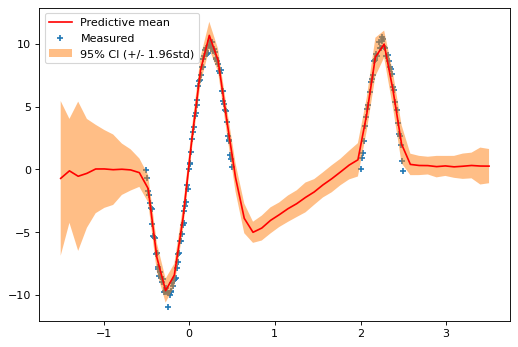

In [7]:
X_test = np.linspace(-1.5, 3.5, 50).reshape(-1, 1)
Y_test = np.zeros([len(X_test), 100])
for j in range(100):
    Y_test[:,j]= np.squeeze(model.predict(X_test))
Pred = np.mean(Y_test, axis=1)
Stdv = np.std(Y_test, axis=1)

X_test = np.squeeze(X_test)  
cm = 1/2.54 
fig, ax = plt.subplots(1, figsize=(17*cm, 12*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.plot(X_test, Pred, 'r-', label='Predictive mean');
ax.scatter(X,Y, marker='+', label='Measured');
ax.fill_between(X_test,Pred+1.96*Stdv,Pred-1.96*Stdv,
                 alpha=0.5, label='95% CI (+/- 1.96std)')
ax.legend()